# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета в файле get_dataset.py


# Vanilla Autoencoder

## Prepare the data


In [2]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import time
import copy
from torchvision import transforms, models
from copy import deepcopy

get_dataset.py приходится подгружать в рабочую директорию руками(

In [22]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Теперь разобьем на train и val, а также приведем к тезорам pytorch

In [23]:
data.shape

(13143, 45, 45, 3)

In [24]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE

Реализуем случайное разбиение датасета

In [25]:
ix = np.random.choice(len(data), len(data), False)
tr, val = np.split(ix, [TRAIN_SIZE])

In [26]:
X_train = data[tr]
X_val = data[val]

In [27]:
X_train.shape

(10000, 45, 45, 3)

Функция отрисовки **n_row ⋅ n_co**l первых картинок в массиве **images**

In [28]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass

Проверим нашу функцию

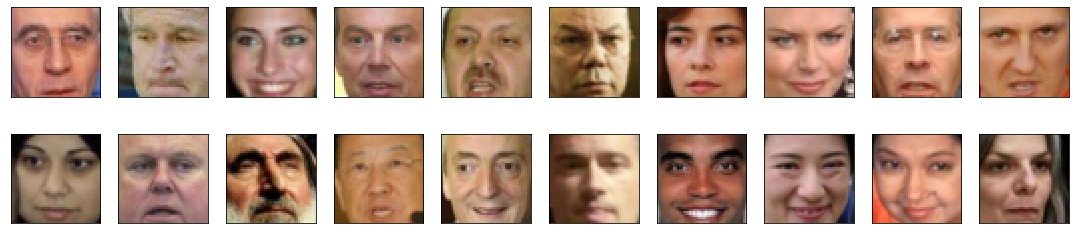

In [29]:
plot_gallery(X_train, IMAGE_H, IMAGE_W, n_row=2, n_col=10)

Создадим теперь списки тензоров для подачи в даталодер

In [30]:
x_train = []
x_val = []

In [31]:
for i in range(TRAIN_SIZE):
  x_train.append(transforms.ToTensor()(X_train[i]))
  x_train[i] = x_train[i].float()

for i in range(VAL_SIZE):
  x_val.append(transforms.ToTensor()(X_val[i]))
  x_val[i] = x_val[i].float()
  

In [32]:
x_train[0].shape

torch.Size([3, 45, 45])

И скормим даталодеру

In [33]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(x_train, batch_size=batch_size, shuffle=True)
data_val = DataLoader(x_val, batch_size=batch_size, shuffle=True)

## Autoencoder
В этом разделе мы напишем и обучим обычный автоэнкодер.


In [34]:
dim_code = 100 # размер латентного вектора, т.е. code, самой "узкой" части автоэнкодера

Обозначим размер входной картинки

In [35]:
inp_size=X_train.shape[1]

In [36]:
inp_size

45

Реализуем архитектуру со сверточными слоями

In [41]:
class AutoencoderConv(nn.Module):
    def __init__(self):
      super().__init__()
      self.enc_cnn_1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
      self.enc_cnn_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
      self.enc_cnn_3 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=3, padding=1) # 50 * 10 * 10
      self.enc_linear_1 = nn.Linear(50 * 5 * 5, 11 * 11 * 20)
      self.enc_linear_2 = nn.Linear(11 * 11 * 20, 200)
      self.enc_linear_3 = nn.Linear(200, dim_code)
      self.dec_linear_1 = nn.Linear(dim_code, 11 * 11 * 20)
      self.dec_linear_2 = nn.Linear(11 * 11 * 20, 50 * 5 * 5)
      self.dec_cnn_1 = nn.ConvTranspose2d(in_channels = 50 , out_channels = 20, kernel_size = 3, stride = 2) #20 * 11 * 11
      self.dec_cnn_2 = nn.ConvTranspose2d(in_channels = 20 , out_channels = 10, kernel_size = 2, stride = 2) #10 * 22 * 22
      self.dec_cnn_3 = nn.ConvTranspose2d(in_channels = 10 , out_channels = 3, kernel_size = 3, stride = 2) #3 * 45 * 45

    def forward(self, x):
      latent_code = self.encode(x)
      reconstruction = self.decode(latent_code)        
      return reconstruction, latent_code
    
    def encode(self, images):
      code = self.enc_cnn_1(images) # 10,45,45
      code = F.relu(F.max_pool2d(code, 2)) # 10,22,22
      code = self.enc_cnn_2(code)  # 20,22,22
      code = F.relu(F.max_pool2d(code, 2)) # 20,11,11
      code = self.enc_cnn_3(code)  # 50,10,10
      code = F.relu(F.max_pool2d(code, 2)) # 50,5,5
      code = code.view([-1, 50 * 5 * 5])
      code = code.view([-1, 50 * 5 * 5])
      code = F.relu(self.enc_linear_1(code))
      code = F.relu(self.enc_linear_2(code))
      code = (self.enc_linear_3(code))
      return code

    def decode(self, code):
      out = F.relu(self.dec_linear_1(code)) # 11 * 11 * 20
      out = F.relu(self.dec_linear_2(out))
      out = out.view([-1, 50, 5, 5]) 
      out = F.relu(self.dec_cnn_1(out))
      out = F.relu(self.dec_cnn_2(out))  #10 * 22 * 22
      out = F.sigmoid(self.dec_cnn_3(out))
      return out

И с линейными

In [42]:
class AutoencoderLinear(nn.Module):
    def __init__(self):
      super().__init__()
      self.enc_cnn_1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1)
      self.enc_cnn_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
      self.enc_linear_1 = nn.Linear(11 * 11 * 20, 200)
      self.enc_linear_2 = nn.Linear(200, dim_code)
      


      self.dec_linear_1 = nn.Linear(dim_code, 11 * 11 * 20)
      self.dec_linear_2 = nn.Linear(11 * 11 * 20, 45 * 45 * 3)
      #  <определите архитектуры encoder и decoder>
        
    def forward(self, x):
      latent_code = self.encode(x)
      reconstruction = self.decode(latent_code)

      #  <реализуйте forward проход автоэнкодера
      #  в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
      #  и полученная реконструкция изображения (reconstruction)>
        
      return reconstruction, latent_code
    
    def encode(self, images):
      code = self.enc_cnn_1(images) # 10,45,45
      code = F.relu(F.max_pool2d(code, 2)) # 10,22,22
      code = self.enc_cnn_2(code)  # 20,22,22
      code = F.relu(F.max_pool2d(code, 2)) # 20,11,11

      code = code.view([-1, 11 * 11 * 20])
      code = F.relu(self.enc_linear_1(code))
      code = F.sigmoid(self.enc_linear_2(code))
      return code

    def decode(self, code):
      out = F.relu(self.dec_linear_1(code))
      out = F.sigmoid(self.dec_linear_2(out))
      out = out.view([-1, 3, 45, 45])
      return out

In [43]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Обучим нашу модель

In [44]:
criterion = nn.MSELoss()

autoencoderLin = AutoencoderLinear().to(device)
autoencoderConv = AutoencoderConv().to(device)
optimizer_conv = torch.optim.Adam(autoencoderConv.parameters(), lr=0.001)
optimizer_lin = torch.optim.Adam(autoencoderLin.parameters(), lr=0.001)
n_epochs = 40
history_train_Lin = []
history_val_Lin = []
history_train_conv = []
history_val_conv = []

In [45]:
def train_val(autoencoder, optimizer, n_epochs, criterion, history_train, history_val):
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0
        val_loss = 0.0
        # train the model
        for images in data_tr:
            images = images.to(device)
            optimizer.zero_grad()
            reconstruction, latent_code = autoencoder(images)
            loss = criterion(reconstruction, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.cpu().detach().numpy()
        #plot_gallery([images[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[9].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        

        train_loss = train_loss/len(data_tr)
        history_train.append(train_loss)
    
        for images in data_val:
            images = images.to(device)
            reconstruction, latent_code = autoencoder(images)
            loss = criterion(reconstruction, images)
            val_loss += loss.cpu().detach().numpy()

        val_loss = val_loss/len(data_val)
        history_val.append(val_loss)
    
        #plot_gallery([images[0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        

        print('Epoch: {} \tTraining Loss: {:.6f},\tval Loss: {:.6f} '.format(
            epoch, 
            train_loss,
            val_loss
            ))

In [46]:
train_val(autoencoderConv, optimizer_conv, n_epochs, criterion, history_train_conv, history_val_conv)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.021557,	val Loss: 0.012689 
Epoch: 2 	Training Loss: 0.012189,	val Loss: 0.011718 
Epoch: 3 	Training Loss: 0.010936,	val Loss: 0.010142 
Epoch: 4 	Training Loss: 0.010032,	val Loss: 0.009525 
Epoch: 5 	Training Loss: 0.009338,	val Loss: 0.008925 
Epoch: 6 	Training Loss: 0.008784,	val Loss: 0.008580 
Epoch: 7 	Training Loss: 0.008503,	val Loss: 0.008356 
Epoch: 8 	Training Loss: 0.008099,	val Loss: 0.007889 
Epoch: 9 	Training Loss: 0.007640,	val Loss: 0.007448 
Epoch: 10 	Training Loss: 0.007319,	val Loss: 0.007345 
Epoch: 11 	Training Loss: 0.007146,	val Loss: 0.007199 
Epoch: 12 	Training Loss: 0.006935,	val Loss: 0.007084 
Epoch: 13 	Training Loss: 0.006695,	val Loss: 0.006792 
Epoch: 14 	Training Loss: 0.006500,	val Loss: 0.006763 
Epoch: 15 	Training Loss: 0.006364,	val Loss: 0.006666 
Epoch: 16 	Training Loss: 0.006206,	val Loss: 0.006324 
Epoch: 17 	Training Loss: 0.006053,	val Loss: 0.006456 
Epoch: 18 	Training Loss: 0.005971,	val Loss: 0.006338 
E

In [47]:
train_val(autoencoderLin, optimizer_lin, n_epochs, criterion, history_train_Lin, history_val_Lin)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.013829,	val Loss: 0.009982 
Epoch: 2 	Training Loss: 0.009308,	val Loss: 0.008469 
Epoch: 3 	Training Loss: 0.007968,	val Loss: 0.007548 
Epoch: 4 	Training Loss: 0.007287,	val Loss: 0.007022 
Epoch: 5 	Training Loss: 0.006766,	val Loss: 0.006595 
Epoch: 6 	Training Loss: 0.006356,	val Loss: 0.006273 
Epoch: 7 	Training Loss: 0.006020,	val Loss: 0.006084 
Epoch: 8 	Training Loss: 0.005704,	val Loss: 0.005786 
Epoch: 9 	Training Loss: 0.005480,	val Loss: 0.005656 
Epoch: 10 	Training Loss: 0.005257,	val Loss: 0.005447 
Epoch: 11 	Training Loss: 0.005021,	val Loss: 0.005506 
Epoch: 12 	Training Loss: 0.004845,	val Loss: 0.005201 
Epoch: 13 	Training Loss: 0.004679,	val Loss: 0.005120 
Epoch: 14 	Training Loss: 0.004543,	val Loss: 0.005075 
Epoch: 15 	Training Loss: 0.004437,	val Loss: 0.004937 
Epoch: 16 	Training Loss: 0.004319,	val Loss: 0.004858 
Epoch: 17 	Training Loss: 0.004211,	val Loss: 0.004857 
Epoch: 18 	Training Loss: 0.004127,	val Loss: 0.004825 
E

Посмотрим на графики лоссов

In [48]:
def graphics(history_train, history_val, n_epochs):
  epochs = np.linspace(1,n_epochs, n_epochs)
  plt.figure(figsize=(15, 9))
  plt.plot(history_train_conv, label="train")
  plt.plot(history_val_conv, label="val")
  plt.legend(loc='best')
  plt.xlabel("epochs")
  plt.ylabel("score")
  plt.show()

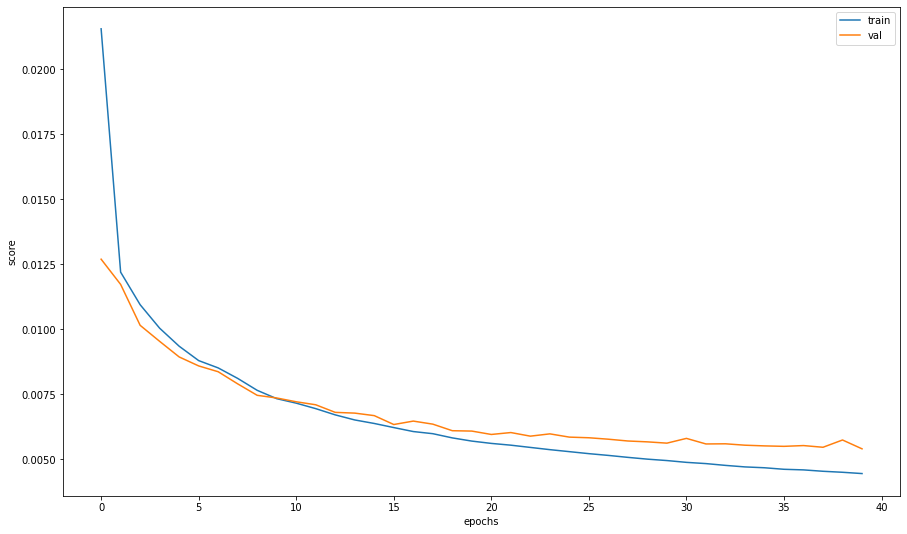

In [49]:
graphics(history_train_Lin, history_val_Lin, n_epochs)

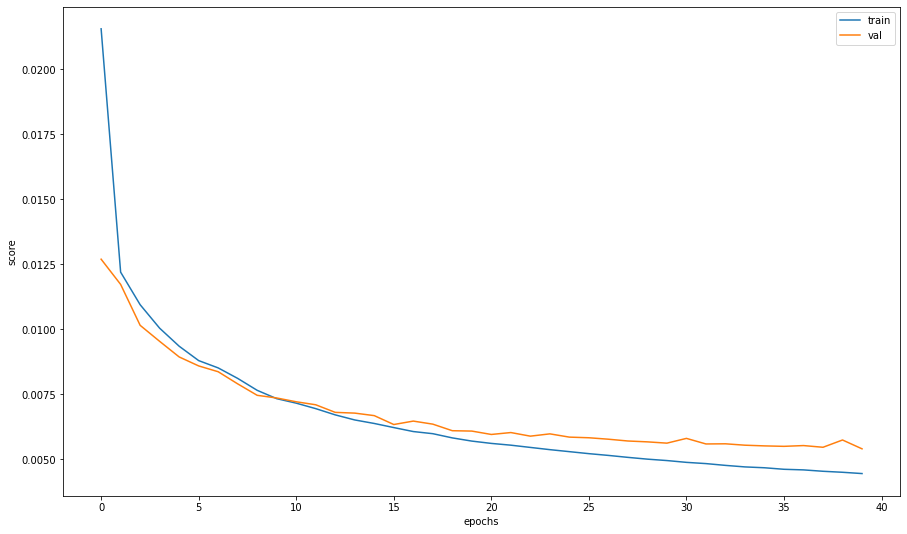

In [50]:
graphics(history_train_conv, history_val_conv, n_epochs)

Посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


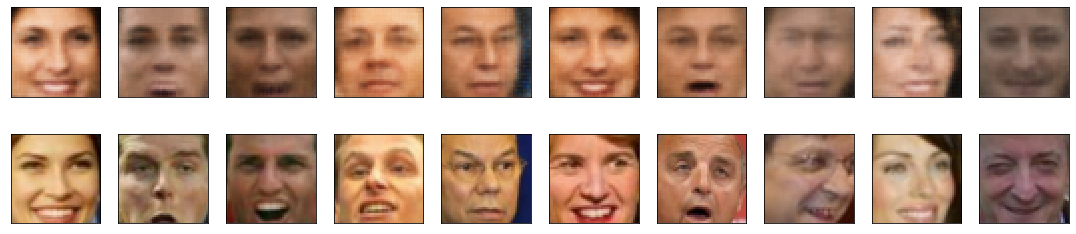

In [51]:
for images in data_val:
        images = images.to(device)
        reconstruction, latent_code = autoencoderConv(images)
        break;
a = reconstruction.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
b = images.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
plot_gallery(np.concatenate((a,b), axis=0), IMAGE_H, IMAGE_W, n_row=2, n_col=10)        

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


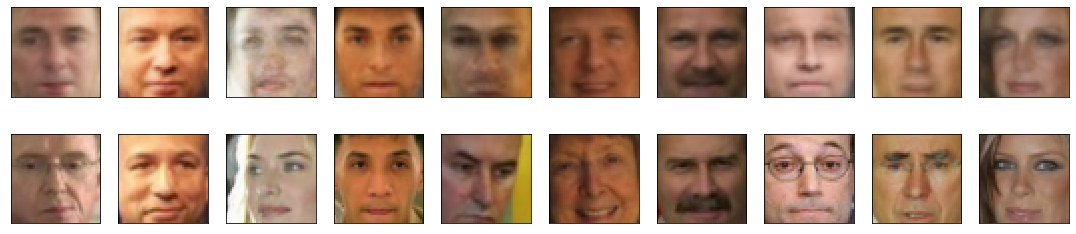

In [52]:
for images in data_val:
        images = images.to(device)
        reconstruction, latent_code = autoencoderLin(images)
        break;
a = reconstruction.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
b = images.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
plot_gallery(np.concatenate((a,b), axis=0), IMAGE_H, IMAGE_W, n_row=2, n_col=10)        

## Sampling

Попробуем восстановить лицо из случайного вектора

С сверточным автоэнкодером

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


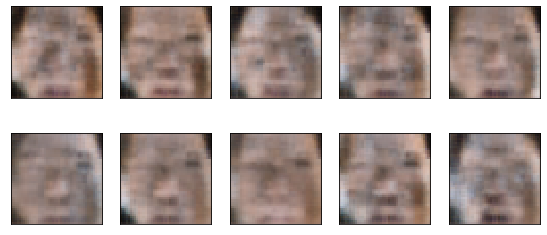

In [53]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.rand(25,100).to(device)
output = autoencoderConv.decode(z)
plot_gallery(output.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


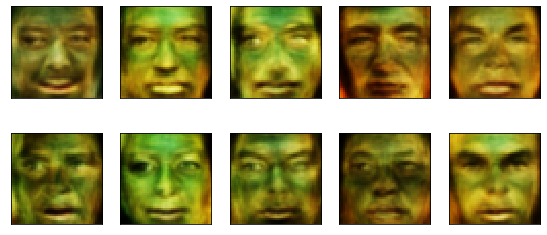

In [54]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.rand(25,100).to(device)
output = autoencoderLin.decode(z)
plot_gallery(output.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

Как видим, хотя автоэнкодер с линейными слоями сгенерировал что-то более похожее на лица, это все равно далеко от удовлетворительного качества. Это связано с недостатками самой архитектуры, которая не позволяет "удобно" учитывать распределение внутри латентного кода, в отличие от VAE, которые будут рассмотрены позднее

## Дорисовываем улыбки

Нужно выделить "вектор улыбки", а именно из латентного вектора улыбающихся людей вычесть латентный вектор грустных, потом если к латентному вектору грустного добавить "вектор улыбки" и прогнать через декодер, то он начнет улыбаться

Разобьем датафрейм атрибутов на train и val

In [55]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.56835,-1.88904,1.7372,-0.929729,-1.4718,-0.19558,-0.835609,-0.351468,-1.01253,-0.719593,-0.632401,0.464839,-0.973528,1.56519,-1.2967,-1.54272,-0.684671,-0.86499,0.766886,-0.218952,-1.65567,-0.787044,-0.599665,0.458519,0.18976,0.851555,-0.38572,-0.497719,-0.161149,-0.257514,-0.0888388,0.455469,-0.839211,-0.0229481,-0.922568,-0.114539,1.46122,1.75848,0.0688935,1.26786,-1.12024,0.917617,-1.30796,-1.50041,1.02922,0.832363,-0.498657,0.251365,-0.705281,-0.515715,0.374239,-0.168675,-0.614143,3.0977,1.52386,0.779278,-0.0714539,-1.24648,-0.769283,-0.725597,-1.82061,-2.07298,-0.960759,0.361738,1.16612,-1.16492,-1.13999,-2.37175,-1.29993,-0.414682,-1.1449,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.28218,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,-0.736883,0.294554,-1.27765,0.954771,-0.990992,-1.16736,-0.835146,0.798544,-0.971679,0.342826,-1.32256,0.962937,-1.19936,-0.157307,0.443224,-0.00288156,-0.0211584,-0.226563,-0.0810386,-0.827202,-0.106624,1.22759,-0.812223,-1.24126,0.0962725,-0.404544,0.325919,0.474452,1.13536,0.0587247,0.611176,-1.17251,0.428512,-0.874235,-1.19156,0.192359,-0.204166,0.342347,0.239512,-1.47469,0.236057,-0.565208,-0.712542,2.99708,-0.273306,-0.187722,-0.604608,-1.3217,-0.938559,0.494294,-0.659043,-1.14375,-0.775722,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.00624408,-0.0304057,-0.480128,0.66676,-0.496559
2,0.997749,-1.36419,-0.157377,-0.756447,-1.89183,-0.871526,-0.862893,0.0314447,-1.34152,-0.0900375,-1.20073,-0.33246,-0.537006,1.29836,-1.49847,-1.28582,1.14174,0.172817,0.106412,-0.788843,0.349295,-1.64372,0.454287,1.18946,-0.688414,-0.590574,-0.266673,0.467224,0.567348,-1.7191,0.124667,1.60274,-0.659399,-1.75376,1.20447,0.0221884,-1.13544,1.70286,-0.422144,0.587859,0.414363,0.344447,-1.26045,-0.577746,0.405567,-1.91655,0.92126,0.247437,-0.428451,-0.772273,0.370673,-0.509596,-0.768482,1.7069,0.126524,-0.497001,-0.393042,-0.178307,-1.18023,-0.596914,-1.80538,-0.951643,-0.838087,1.54974,1.88475,-0.999765,-1.35986,-1.91211,-1.09563,0.915126,-0.572332,0.144262,-0.841231
3,1.12272,-1.9978,1.91614,-2.51421,-2.58007,-1.40424,0.0575511,0.000195882,-1.27351,-1.43146,-0.0705188,-0.339239,-2.00415,0.665695,-0.77594,-1.47163,-1.17908,0.563327,-0.664429,-1.40793,0.435594,-0.589988,-1.6035,1.17074,0.760103,0.211498,-0.51618,-1.33115,0.20284,0.149645,-0.0464296,0.640885,-0.107616,-0.831271,-0.827005,-0.588725,0.429255,1.58766,0.499086,-0.0568692,-0.866643,-0.959689,0.35073,-1.33535,-0.42789,0.826817,-0.256779,0.149751,-1.20153,-1.08392,0.255363,-0.650423,-0.506293,1.10159,0.640783,1.57503,-0.484397,-1.55968,-1.43712,0.379363,-0.648233,-2.25735,-1.07561,0.567822,-0.176089,1.10812,-1.60094,-3.26461,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.07821,-2.0081,1.67621,-2.27806,-2.65185,-1.34841,0.649089,0.0176564,-1.88911,-1.85721,-0.568057,0.840375,-1.98127,1.66671,-0.910723,-1.99351,-0.871335,0.507786,-0.488947,-0.88649,-0.990132,-0.750813,-0.378479,0.583086,-1.4796,0.250185,-0.381123,-0.611991,-0.143091,-1.07276,0.432094,1.08919,-0.470929,-1.17712,-0.111313,-0.154603,-1.03151,2.39246,-0.191576,1.2279,-1.3818,-1.52885,0.907964,-1.32429,-0

In [56]:
attrs_tr = attrs.iloc[tr]
attrs_val = attrs.iloc[val]

In [57]:
attrs_tr.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
5520,1.80688,-0.122235,-0.251768,-1.72656,-2.61182,-1.27956,0.179368,-0.340886,0.00771463,-1.15283,-1.22549,-1.6852,-1.32533,-0.326009,0.99474,-0.853793,-0.752861,-1.75515,1.6229,-1.26704,-0.718898,-0.678242,-0.00319279,0.401257,-0.305164,0.786918,-0.2401,-0.760787,1.18077,0.314213,0.00954818,-0.251895,-0.296934,-0.386101,0.772245,-0.742609,0.18204,1.44161,0.0180739,0.158734,0.340754,-0.541308,0.148974,-1.06783,1.62023,0.485136,-0.368376,0.000495075,-0.60085,0.818276,0.694858,-0.079822,-0.93272,7.14888,0.885177,-1.1832,-1.32962,-0.929217,0.218993,0.59702,-0.653759,-0.367813,-0.958543,-1.16411,-0.0159819,-0.708929,-1.25861,0.526194,-1.41104,0.673061,-0.713098,0.838557,-1.28309
3963,1.31426,-1.25179,1.10647,-0.744468,-1.74773,-0.938645,-1.11519,-0.32576,-0.0670464,-0.595286,-0.917048,-3.00893,-0.765002,1.7694,-0.649287,-1.37977,0.0909488,-0.910243,0.957814,0.271997,-0.913862,-0.936053,-1.32711,1.47364,0.656013,2.18318,0.228286,-1.52584,1.18525,-0.186132,0.486896,0.094988,-0.448202,-0.0234812,0.597556,-1.21894,2.30508,-1.0519,0.709226,0.0797029,-0.548138,-0.072316,-0.708729,-0.439533,0.484643,0.0556071,-0.119289,0.227704,-0.0279062,-0.122992,-0.239978,-0.160833,-1.03021,1.03705,-1.29738,0.692463,-1.18862,-1.14257,-0.0218424,-0.017591,-1.88034,-2.45814,-1.13209,2.11939,0.23025,-0.727083,-1.84729,-3.10258,-1.23146,1.58202,-0.988597,0.702762,-0.602838
11648,-1.82743,-1.93086,1.32201,-2.11047,-2.15704,-1.35374,0.825361,-0.250007,-2.07907,-0.0051709,-0.786376,-0.0152425,-0.944472,1.40465,-0.689338,-1.60041,-1.64873,1.62542,-1.76798,-1.32449,-0.388978,-1.7228,0.852549,0.527634,-1.53981,-0.822838,0.503113,0.036608,-1.4794,-1.64367,-0.666883,0.81987,-1.24243,-2.05306,-0.61722,0.100028,-1.48651,1.81094,-0.380092,0.84845,0.0640356,-0.803831,1.13552,-1.22503,-1.62736,1.5428,-1.49503,0.420616,-1.13805,-0.953231,1.1549,-0.651734,-1.00384,3.44863,0.483815,0.375218,0.512,-0.645229,-1.86728,-1.25656,0.933335,1.40405,0.603646,1.97953,-1.28578,0.73378,1.32519,-0.155685,1.67464,-0.456621,0.841203,-0.76994,1.10566
12447,1.5619,-1.35299,1.3153,-0.68792,-2.42301,-2.04173,-1.44162,0.0734111,0.453652,-1.08615,-0.661943,1.12441,-1.03184,0.690764,0.108494,-1.81932,-0.408691,-0.715355,0.587595,-0.063964,-2.0283,-0.00232358,-0.591357,1.27721,0.0197719,-0.364649,-0.825034,-0.319558,1.72764,-1.3136,-0.0562069,1.73986,-1.2335,-1.03681,0.423601,-0.155186,0.35477,0.997106,0.80781,0.552723,0.369878,-0.356245,-0.104162,-0.997773,0.390276,0.276967,0.000623721,-0.378626,-0.372245,-1.83573,0.541206,-0.103488,-1.11878,2.70945,0.86019,-0.787742,-1.03954,-2.00076,-0.459774,1.33543,-1.00848,-0.884308,-1.19517,1.20261,0.331747,0.254599,-1.38077,-3.08906,-0.36064,-0.933005,-0.838039,1.48998,-0.668858
10438,1.0837,-0.699432,0.79662,-1.73782,-0.369957,-1.7542,-1.02273,-0.0817964,-0.490087,0.118326,-0.312521,-1.19921,0.00106483,1.7775,-1.74008,-1.2978,0.478361,0.123898,0.226425,0.475314,-1.15821,-0.469458,0.0907404,0.886206,-0.875004,-0.757004,-1.03775,0.347285,-0.221211,-1.14248,-0.270103,2.53023,-0.726071,-1.13341,-0.496521,-0.635958,0.289132,1.14765,0.118379,0.567925,-0.423152,-2.19311,0.141685,-0.168881,-0.747221,-0.68

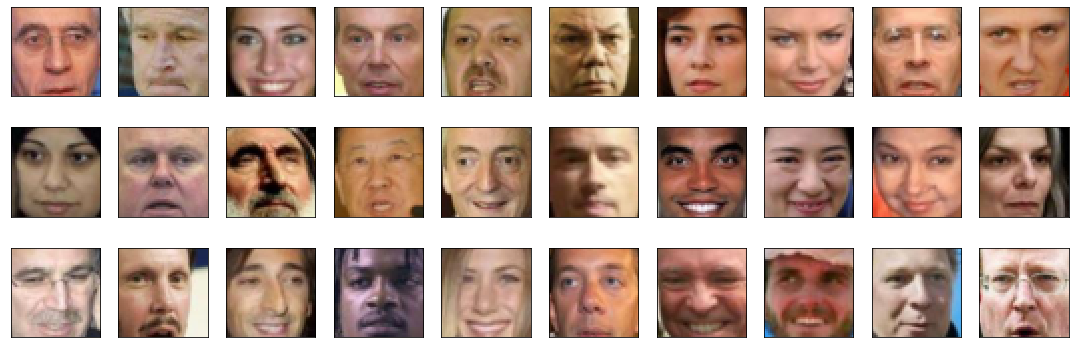

In [58]:
plot_gallery(X_train, IMAGE_H, IMAGE_W, n_row=3, n_col=10)

In [59]:
SAD = []
SMILE = []

In [60]:
k = -1
for i in tr[:300]:
  k += 1
  if (attrs.loc[i]['Smiling'] > 1.5):
    SMILE.append(X_train[k])
  elif (attrs.loc[i]['Smiling'] < -1):
    SAD.append(X_train[k])
    #print(i, attrs.loc[i]['Smiling'])

In [61]:
len(SAD)

76

In [62]:
len(SMILE)

28

In [63]:
lenlist = min(len(SMILE), len(SAD))
SMILE = SMILE[:lenlist]
SAD = SAD[:lenlist]

Посмотрим, какие картинки мы выбрали

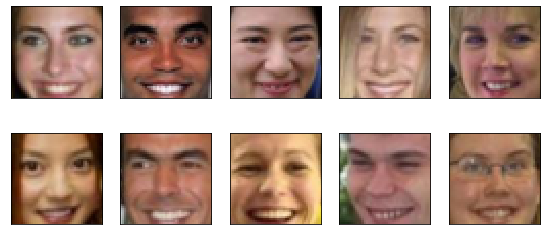

In [64]:
plot_gallery(SMILE, IMAGE_H, IMAGE_W, n_row=2, n_col=5)

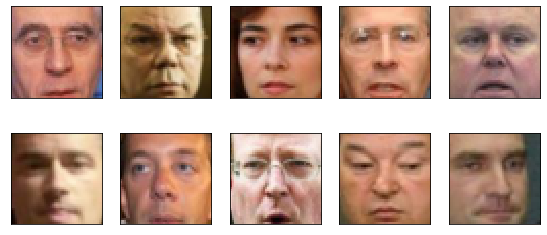

In [65]:
plot_gallery(SAD, IMAGE_H, IMAGE_W, n_row=2, n_col=5)

In [66]:
SMILE_TENSOR  = torch.Tensor(lenlist,3,45,45)
SAD_TENSOR = torch.Tensor(lenlist,3,45,45)
for i in range (lenlist):
  SMILE_TENSOR[i] = transforms.ToTensor()(SMILE[i]).float()
  SAD_TENSOR[i] = transforms.ToTensor()(SAD[i]).float()

In [67]:
SMILE_TENSOR = SMILE_TENSOR.to(device)
SAD_TENSOR = SAD_TENSOR.to(device)

In [68]:
SMILE_VECTOR = autoencoderLin.encode(SMILE_TENSOR)
SAD_VECTOR = autoencoderLin.encode(SAD_TENSOR)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [69]:
VECTOR =  SMILE_VECTOR.mean(axis=0) - SAD_VECTOR.mean(axis=0)

In [70]:
reconstruction, latent_code = autoencoderLin(images)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [71]:
latent_code = latent_code + VECTOR
latent_code = latent_code.to(device)

In [72]:
images_smile = autoencoderLin.decode(latent_code)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [73]:
d = images_smile.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)

Посмотрим, как получилось:

До

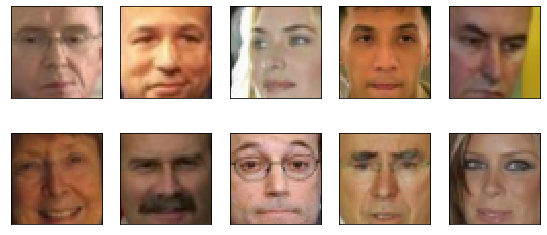

In [74]:
plot_gallery(b, IMAGE_H, IMAGE_W, n_row=2, n_col=5)        

После

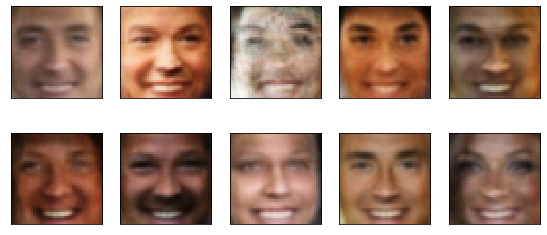

In [75]:
plot_gallery(d, IMAGE_H, IMAGE_W, n_row=2, n_col=5)        

Этот метод можно применять к любому атрибуту из датафрейма

# Variational Autoencoder

Подготовим датасет, для простоты будем использовать MNIST, а не Labeled faces in the wild

In [76]:
import torchvision
from torchvision import datasets, transforms
dataset_train = datasets.MNIST(root='MNIST',
                               train=True,
                               transform = transforms.ToTensor(),
                               download=True)
dataset_test  = datasets.MNIST(root='MNIST', 
                               train=False, 
                               transform = transforms.ToTensor(),
                               download=True)
batch_size = 128
num_workers = 2
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               batch_size = batch_size,
                                               shuffle=True,
                                               num_workers = num_workers, 
                                               pin_memory=True)

dataloader_test = torch.utils.data.DataLoader(dataset_test,
                                               batch_size = batch_size,
                                               num_workers = num_workers,
                                               pin_memory=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Функция для отрисовки MNISTа:

In [77]:
def plot_gallery_MNIST(dataset, h = 28, w = 28, n_row=3, n_col=6):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(dataset[i].numpy().squeeze(), cmap='gray', vmin=-1, vmax=1)
            plt.xticks(())
            plt.yticks(())
        except:
            pass

Построим архитектуру нашей сети

Используем увеличенное количество слоев и сверточные слои в декодере, чтобы получить приемлемое качество


In [78]:
dim_code = 100

In [79]:
from copy import deepcopy
class VAE(nn.Module):
    def __init__(self):
      super().__init__()
      self.enc_cnn_1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=1)
      self.enc_cnn_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1)
      self.enc_cnn_3 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=2, padding=1)
      
      self.enc_linear_1 = nn.Linear(50 * 4 * 4, 7 * 7 * 20)
      self.enc_linear_2 = nn.Linear(7 * 7 * 20, 200)
      
      self.enc_linear_3_mu = nn.Linear(200, dim_code)
      self.enc_linear_3_logsigma = nn.Linear(200, dim_code)
      
      
      self.dec_linear_1 = nn.Linear(dim_code, 7 * 7 * 20)
      self.dec_linear_2 = nn.Linear(7 * 7 * 20, 50 * 4 * 4)
      
      self.dec_cnn_1 = nn.ConvTranspose2d(in_channels = 50 , out_channels = 20, kernel_size = 3, stride = 1)
      self.dec_cnn_2 = nn.ConvTranspose2d(in_channels = 20 , out_channels = 10, kernel_size = 3, stride = 2)
      self.dec_cnn_3 = nn.ConvTranspose2d(in_channels = 10 , out_channels = 1, kernel_size = 4, stride = 2)


    
    def encode(self, images):
      #print('Вход в енкодер', images.shape)
      code = self.enc_cnn_1(images)
      
      code = F.relu(F.max_pool2d(code, 2))
      #print('Первый слой', code.shape)
      code = self.enc_cnn_2(code)
      code = F.relu(F.max_pool2d(code, 2))
      #print('Второй слой', code.shape)
      code = self.enc_cnn_3(code)
      code = F.relu(F.max_pool2d(code, 2))
      #print('Третий слой', code.shape)

      code = code.view([-1, 50 * 4 * 4])
      code = code.view([-1, 50 * 4 * 4])
      code = F.relu(self.enc_linear_1(code))
      code = F.relu(self.enc_linear_2(code))


      mu = self.enc_linear_3_mu(code)
      logsigma = self.enc_linear_3_logsigma(code) 

      return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, code):
      out = F.relu(self.dec_linear_1(code))
      out = F.relu(self.dec_linear_2(out))
      out = out.view([-1, 50, 4, 4]) 
      
      out = F.relu(self.dec_cnn_1(out))
      out = F.relu(self.dec_cnn_2(out))
      out = F.sigmoid(self.dec_cnn_3(out))
      return out

    def forward(self, x):
      mu, logsigma = self.encode(x)
      reconstruction = self.gaussian_sampler(mu, logsigma)
      reconstruction = self.decode(reconstruction)


      return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

In [80]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = (-0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())) / (28 * 28)
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy(reconstruction, x)
    return loss

def loss_vae(x, mu, logsigma, reconstruction):
    #print(KL_divergence(mu, logsigma), log_likelihood(x, reconstruction))
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

Теперь обучим модель:

In [81]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [82]:
criterion = loss_vae

VAE_autoencoder = VAE().to(device)

optimizer = torch.optim.Adam(VAE_autoencoder.parameters(), lr=0.001)

n_epochs = 50
history_train_VAE = []
history_val_VAE = []

In [83]:
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    val_loss = 0.0
    for images, labels in dataloader_train:
        images = images.to(device)
        optimizer.zero_grad()
        mu, logsigma, reconstruction = VAE_autoencoder(images)

        loss = criterion(images, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().detach().numpy()
    train_loss = train_loss/len(dataloader_train)
    history_train_VAE.append(train_loss)
    
    for images, labels in dataloader_test:
        images = images.to(device)
        mu, logsigma, reconstruction = VAE_autoencoder(images)
        loss = criterion(images, mu, logsigma, reconstruction)
        val_loss += loss.cpu().detach().numpy()
 
    val_loss = val_loss/len(dataloader_test)
    history_val_VAE.append(val_loss)
    
    
    print('Epoch: {} \tTraining Loss: {:.6f},\tval Loss: {:.6f} '.format(
        epoch, 
        train_loss,
        val_loss
        )) 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.379477,	val Loss: 0.310017 
Epoch: 2 	Training Loss: 0.241736,	val Loss: 0.230060 
Epoch: 3 	Training Loss: 0.192616,	val Loss: 0.170344 
Epoch: 4 	Training Loss: 0.157141,	val Loss: 0.143311 
Epoch: 5 	Training Loss: 0.136647,	val Loss: 0.129242 
Epoch: 6 	Training Loss: 0.122473,	val Loss: 0.118392 
Epoch: 7 	Training Loss: 0.113403,	val Loss: 0.109511 
Epoch: 8 	Training Loss: 0.107344,	val Loss: 0.104142 
Epoch: 9 	Training Loss: 0.102584,	val Loss: 0.098253 
Epoch: 10 	Training Loss: 0.099247,	val Loss: 0.096212 
Epoch: 11 	Training Loss: 0.096566,	val Loss: 0.094407 
Epoch: 12 	Training Loss: 0.094782,	val Loss: 0.094555 
Epoch: 13 	Training Loss: 0.093029,	val Loss: 0.092825 
Epoch: 14 	Training Loss: 0.091731,	val Loss: 0.090935 
Epoch: 15 	Training Loss: 0.090546,	val Loss: 0.088808 
Epoch: 16 	Training Loss: 0.089315,	val Loss: 0.088509 
Epoch: 17 	Training Loss: 0.088230,	val Loss: 0.086783 
Epoch: 18 	Training Loss: 0.087379,	val Loss: 0.086121 
E

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [84]:
for images, labels in dataloader_test:
        # _ stands in for labels, here
        # no need to flatten images
        images = images.to(device)
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        mu, logsigma, reconstruction = VAE_autoencoder(images)
        break;

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [85]:
a = reconstruction.to("cpu").detach()
b = images.to("cpu")

In [86]:
a.shape

torch.Size([128, 1, 28, 28])

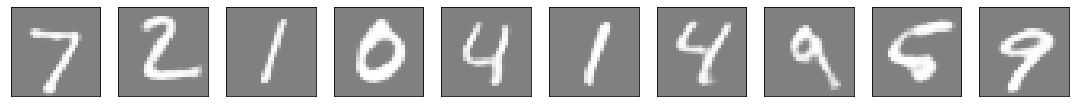

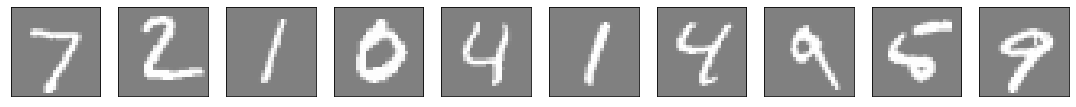

In [87]:
plot_gallery_MNIST(a, 28, 28, n_row=1, n_col=10)
plot_gallery_MNIST(b, 28, 28, n_row=1, n_col=10)   

## Sampling

Попробуем сэмплировать из векторов с нормальным распределением

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


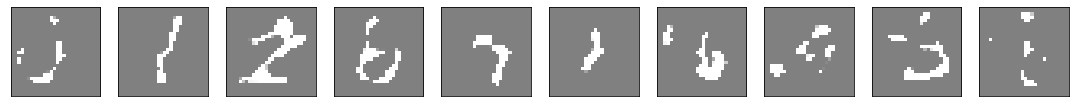

In [88]:
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = VAE_autoencoder.decode(((torch.from_numpy(z)).to(device)).float())

plot_gallery_MNIST(output.to("cpu").detach(), 28, 28, 1, 10)

## Latent Representation

Посмотрим, как латентные векторы картинок лиц выглядят в пространстве. Сжимаем до двумерного с помощью TSNE

In [89]:
lentest = len(dataset_test)

In [90]:
numbers = []
for i in range(lentest):
  numbers.append(dataset_test[i][1])

In [91]:
data_visualization = torch.utils.data.DataLoader(dataset_test, 10, shuffle=False)

In [92]:
latent_vectors=[]
for images, labels in data_visualization:
  images = images.to(device)
  mu, logsigma, reconstruction = VAE_autoencoder(images)
  latent = VAE_autoencoder.gaussian_sampler(mu, logsigma)
  latent_vectors.append(latent.data.cpu().numpy())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [93]:
latent_vectors[0].shape

(10, 100)

In [94]:
final_vectors = []
for vec in latent_vectors:
  for i in range(10):
    final_vectors.append(vec[i])

In [95]:
from sklearn.manifold import TSNE
Emb = TSNE(n_components=2).fit_transform(final_vectors)

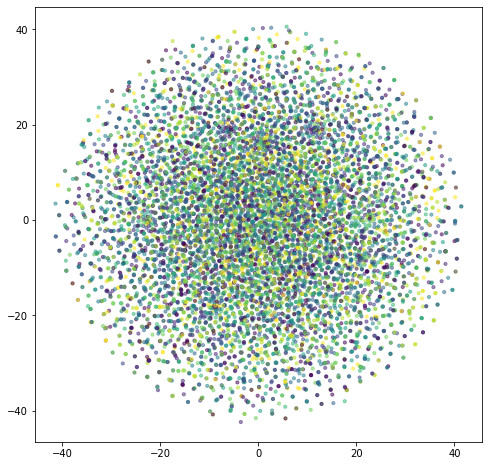

In [96]:
fig, ax = plt.subplots()
ax.scatter(Emb[:,0], Emb[:,1], s=10, alpha=0.5, c = numbers)
fig.set_figwidth(8)
fig.set_figheight(8)

Как видим, раазмерности 2 не хватает, чтобы отразить выученные закономерности, хотя для CVAE этого оказалось достаточно

# Conditional VAE


## Архитектура

Это VAE, на вход которому подается дополнительно еще и информация о классе картинки. Latent у него состоит из mu и sigma все еще.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет


In [97]:
class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(feature_size + class_size, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + class_size, 400)
        self.fc4 = nn.Linear(400, feature_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, c): 
       
        inputs = torch.cat([x, c], 1) 
        h1 = self.relu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparametrize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std) + mu
        else:
            return mu

    def decode(self, z, c): 
     
        inputs = torch.cat([z, c], 1) 
        h3 = self.relu(self.fc3(inputs))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        mu, logvar = self.encode(x.view(-1, 28*28), c)
        z = self.reparametrize(mu, logvar)
        return self.decode(z, c), mu, logvar

Заново загрузим MNIST, чтобы можно было регулировать batchsize, не меняя его для VAE

In [98]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [99]:
import torchvision
from torchvision import datasets, transforms

batch_size = 32
latent_size = 20

kwargs = {'num_workers': 1, 'pin_memory': True}
dataloader_train2 = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
dataloader_test2 = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False,
                       transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [100]:
def train(model, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(dataloader_train2):
        data = to_var(data)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        optimizer.zero_grad()
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader_train2.dataset),
                100. * batch_idx / len(dataloader_train2),
                loss.data / len(data)))

def test(model, epoch):
    model.eval()
    test_loss = 0
    for i, (data, labels) in enumerate(dataloader_test2):
        data = to_var(data)
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = model(data, labels)
        test_loss += loss_function(recon_batch, data, mu, logvar)
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n], recon_batch.view(batch_size, 1, 28, 28)[:n]])
            #save_image(comparison.data.cpu(), 'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(dataloader_test2.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [101]:
def to_var(x):
    x = Variable(x).to(device)
    return x

def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return to_var(targets)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [102]:
CVAE_autoencoder = CVAE(28 * 28, latent_size, 10).to(device)
optimizer = optim.Adam(CVAE_autoencoder.parameters(), lr=1e-3)

In [103]:
for epoch in range(1, 20):
    train(CVAE_autoencoder, epoch)
    test(CVAE_autoencoder, epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.128512
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.007028
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.007777
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.006362
====> Test set loss: 0.0071
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.006881
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.007325
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.006870
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.006942
====> Test set loss: 0.0069
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.007157
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.006905
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.006778
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.006075
====> Test set loss: 0.0069
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.006735
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.006875
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.007010
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.006580
====> Test set loss: 0.0069
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.007298
Train Epoch: 5 [16000/60000 (27%)]	Loss: 0.006932
Train Epoch: 

In [104]:
for images, labels in dataloader_test2:
        # _ stands in for labels, here
        # no need to flatten images
        images = to_var(images)
        labels = (one_hot(labels, 10))
        # clear the gradients of all optimized variables
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, mu, logvar = CVAE_autoencoder(images, labels)
        break;

In [105]:
a = reconstruction.to("cpu").detach().squeeze().reshape(32, 1, 28, 28)

In [106]:
a.shape

torch.Size([32, 1, 28, 28])

In [107]:
b = images.to("cpu")

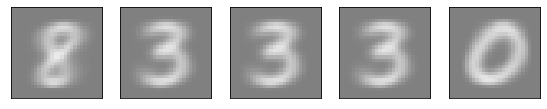

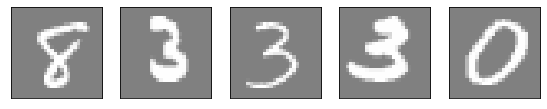

In [108]:
plot_gallery_MNIST(a, 28, 28, 1, 5)
plot_gallery_MNIST(b, 28, 28, 1, 5)

## Sampling


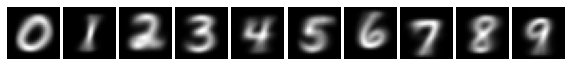

In [109]:
import matplotlib.gridspec as gridspec

c = torch.eye(10, 10)
c = to_var(c)
z = to_var(torch.randn(10, latent_size))
samples = CVAE_autoencoder.decode(z, c).data.cpu().numpy()

fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(10, 10)
gs.update(wspace=0.05, hspace=0.05)
for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='gray')

Наконец-то можно напрямую задавать атрибуты

## Latent Representations

Посмотрим теперь на латентное пространство для CVAE

In [110]:
latent_vectors2=[]
numbers2=[]

In [111]:
for batch_idx, (data, labels) in enumerate(dataloader_train2):
        data = to_var(data)
        numbers2.append(labels.data.cpu().numpy())
        labels = one_hot(labels, 10)
        recon_batch, mu, logvar = CVAE_autoencoder(data, labels)
        z = CVAE_autoencoder.reparametrize(mu, logvar)
        latent_vectors2.append(z.data.cpu().numpy())
   

In [ ]:
numbers_final = []
final_vectors2 = []

In [ ]:
for vec in numbers2:
  for i in range(vec.shape[0]):
    numbers_final.append(vec[i])

for vec in latent_vectors2:
  for i in range(vec.shape[0]):
    final_vectors2.append(vec[i])


In [ ]:
numbers_final = numbers_final[:10000]
final_vectors2 = final_vectors2[:10000]

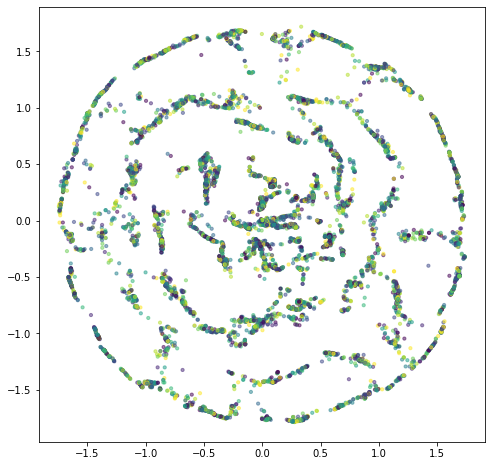

In [115]:
from sklearn.manifold import TSNE
emb = TSNE(n_components=2).fit_transform(final_vectors2)
fig, ax = plt.subplots()
ax.scatter(emb[:,0], emb[:,1], s=10, alpha=0.5,c = numbers_final)
fig.set_figwidth(8)
fig.set_figheight(8)

Теперь наблюдается структура, точки в находятся на неких линиях довольно плотно и большие пустоты между этими линиями, хотя нет явной закономерности между точками разных цветов (представителей разных классов)

# Image Morphing

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

In [117]:
for images in data_tr:
  images = images.to(device)
  reconstruction, latent_code = autoencoderLin(images)
  break;
IMG_1 = images[0]
IMG_2 = images[3]
VEC_1 = latent_code[0]
VEC_2 = latent_code[3]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [118]:
arr = torch.Tensor(11,100)
for i in range(11):
  arr[i] = ((i * 0.1) * VEC_1 + (1 - i * 0.1) * VEC_2)
arr = arr.to(device)

In [121]:
Arr_Pictures = autoencoderLin.decode(arr)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


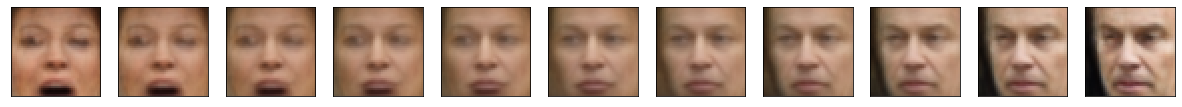

In [122]:
Arr_Pictures_final = Arr_Pictures.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
plot_gallery(Arr_Pictures_final, IMAGE_H, IMAGE_W, n_row=1, n_col=11)    

# Denoising

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения, например, избавление от шума

Вспомогательная функция

In [123]:
def convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  
  image = image.clip(0, 1)
  
  return image

In [124]:
def get_nois(image):
  noise_factor = 0.2
  X_noisy = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape) 
  return X_noisy

In [125]:
NOISE_TRAIN = []
NOISE_VAL = []
for i in range(TRAIN_SIZE):
  NOISE_TRAIN.append((transforms.ToTensor()(X_train[i]), transforms.ToTensor()(get_nois(X_train[i]))))

for i in range(VAL_SIZE):
  NOISE_VAL.append((transforms.ToTensor()(X_val[i]), transforms.ToTensor()(get_nois(X_val[i]))))


Проверим, что все работает

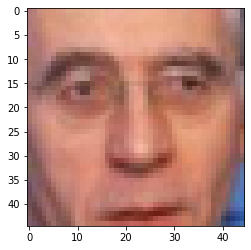

In [126]:
plt.imshow(convert(NOISE_TRAIN[0][0]))

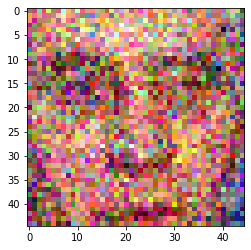

In [127]:
plt.imshow(convert(NOISE_TRAIN[0][1]))

In [128]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr_noise = DataLoader(NOISE_TRAIN, batch_size=batch_size, shuffle=True)
data_val_noise = DataLoader(NOISE_VAL, batch_size=batch_size, shuffle=True)

In [132]:
criterion = nn.MSELoss()

autoencoder_Noise = AutoencoderLinear().to(device)

optimizer = torch.optim.Adam(autoencoder_Noise.parameters(), lr=0.001)
n_epochs = 30
history_train_noise = []
history_val_noise = []

In [133]:
for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    val_loss = 0.0
    for images in data_tr_noise:
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)
        optimizer.zero_grad()

        reconstruction, latent_code = autoencoder_Noise(images[0].float())
        loss = criterion(reconstruction.float(), images[1].float())
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().detach().numpy()

    train_loss = train_loss/len(data_tr_noise)
    history_train_noise.append(train_loss)
    
    for images in data_val_noise:
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)
        reconstruction, latent_code = autoencoder_Noise(images[0].float())
        loss = criterion(reconstruction.float(), images[1].float())
        val_loss += loss.cpu().detach().numpy()

    val_loss = val_loss/len(data_val)
    history_val_noise.append(val_loss)
    
    #plot_gallery([images[0][0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0), reconstruction[0].to("cpu").clone().detach().numpy().squeeze().transpose(1, 2, 0) ], IMAGE_H, IMAGE_W, n_row=1, n_col=2)        

    print('Epoch: {} \tTraining Loss: {:.6f},\tval Loss: {:.6f} '.format(
        epoch, 
        train_loss,
        val_loss
        ))


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.055214,	val Loss: 0.051029 
Epoch: 2 	Training Loss: 0.050170,	val Loss: 0.049384 
Epoch: 3 	Training Loss: 0.048998,	val Loss: 0.048555 
Epoch: 4 	Training Loss: 0.047893,	val Loss: 0.047887 
Epoch: 5 	Training Loss: 0.047239,	val Loss: 0.047482 
Epoch: 6 	Training Loss: 0.046797,	val Loss: 0.047246 
Epoch: 7 	Training Loss: 0.046401,	val Loss: 0.047153 
Epoch: 8 	Training Loss: 0.045984,	val Loss: 0.047108 
Epoch: 9 	Training Loss: 0.045566,	val Loss: 0.047020 
Epoch: 10 	Training Loss: 0.045170,	val Loss: 0.046866 
Epoch: 11 	Training Loss: 0.044844,	val Loss: 0.046889 
Epoch: 12 	Training Loss: 0.044530,	val Loss: 0.046829 
Epoch: 13 	Training Loss: 0.044212,	val Loss: 0.046804 
Epoch: 14 	Training Loss: 0.043964,	val Loss: 0.046958 
Epoch: 15 	Training Loss: 0.043744,	val Loss: 0.046912 
Epoch: 16 	Training Loss: 0.043516,	val Loss: 0.047034 
Epoch: 17 	Training Loss: 0.043338,	val Loss: 0.047284 
Epoch: 18 	Training Loss: 0.043146,	val Loss: 0.047185 
E

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Cl

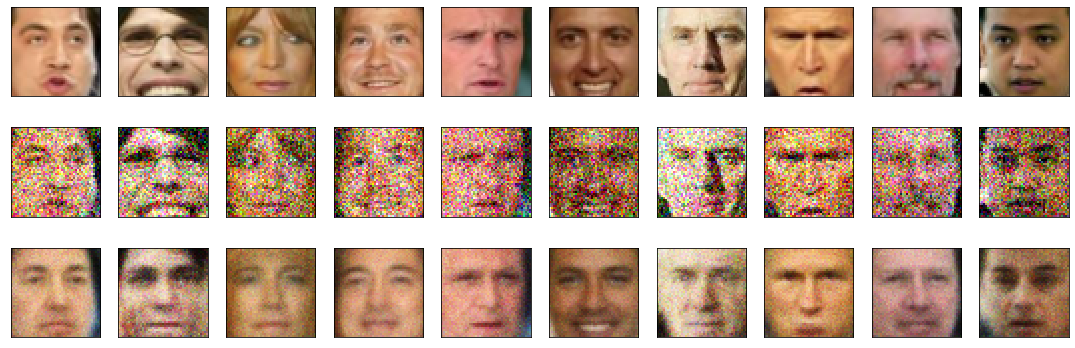

In [134]:
for images in data_val_noise:
        images[0] = images[0].to(device)
        images[1] = images[1].to(device)
        reconstruction, latent_code = autoencoder_Noise(images[0].float())
        break;
a = reconstruction.to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
b = images[0].to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
c = images[1].to("cpu").clone().detach().numpy().squeeze().transpose(0, 2, 3, 1)
plot_gallery(np.concatenate((b, c, a), axis=0), IMAGE_H, IMAGE_W, n_row=3, n_col=10)        

Даже простой автоэнкодер показывает неплохие результаты в избавлении фотографий от шумов